### To Do: 

- mlp introspectors
- coeff error logging


In [1]:
# ==== Imports ====
import argparse
import time
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import torch.nn.functional as F

import os, json, itertools, tempfile, shutil
from pathlib import Path
from collections import OrderedDict




In [2]:
# ==== Device Selection ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# === MLPs ===

class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)

def _tensor_stats(x):
    x = x.detach()
    return dict(
        l1=float(x.abs().sum()),
        l2=float(torch.linalg.norm(x).item()),
        mean=float(x.mean()),
        std=float(x.std()),
        max=float(x.max()),
        min=float(x.min()),
        nnz=int((x!=0).sum().item()),
        numel=x.numel(),
    )

class SimpleMLP(nn.Module):
    def __init__(self, n_layers, hidden_size):
        super(SimpleMLP, self).__init__()
        assert n_layers >= 2, "n_layers must be at least 2"

        layers = []
        # First layer: input (2,) -> hidden_size
        layers.append(nn.Linear(2, hidden_size))
        layers.append(nn.Tanh())

        # Hidden layers: (m -> m)
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        # Final layer: (m -> 1)
        layers.append(nn.Linear(hidden_size, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, t, x):
        input_tensor = torch.cat((t, x), dim=1)  # Concatenate along feature axis
        return self.model(input_tensor)

class LossBalancer(torch.nn.Module):
    def __init__(self, n_terms=3):
        super().__init__()
        self.log_sigmas = torch.nn.Parameter(torch.zeros(n_terms))  # [s_d, s_p, s_s]

    def combine(self, losses):  # list/tuple of scalars
        s = self.log_sigmas
        weighted = sum(torch.exp(-s[i]) * losses[i] + s[i] for i in range(len(losses)))
        return weighted

class symMLP(nn.Module):
    def __init__(self, input_size, n_layers, hidden_size, linear_only=False):
        super(symMLP, self).__init__()
        assert n_layers >= 1, "n_layers must be at least 1"

        layers = []
        if n_layers == 1:
            # Direct input -> output
            layers.append(nn.Linear(input_size, 1))
        else:
            # First layer: input -> hidden
            layers.append(nn.Linear(input_size, hidden_size))
            if not linear_only:
                layers.append(nn.ReLU())
            # Intermediate layers
            for _ in range(n_layers - 2):
                layers.append(nn.Linear(hidden_size, hidden_size))
                if not linear_only:
                    layers.append(nn.ReLU())
            # Final layer
            layers.append(nn.Linear(hidden_size, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):   
        return self.model(x)
   
    def stats(self, with_grads=False):
        """Layer stats + effective input→output coefficients and their stats."""
        out = OrderedDict()
        for i, m in enumerate(self.model):
            if isinstance(m, nn.Linear):
                out[f"layer{i}.weight"] = _tensor_stats(m.weight)
                if m.bias is not None:
                    out[f"layer{i}.bias"] = _tensor_stats(m.bias)
                if with_grads and m.weight.grad is not None:
                    out[f"layer{i}.weight_grad"] = _tensor_stats(m.weight.grad)
                if with_grads and m.bias is not None and m.bias.grad is not None:
                    out[f"layer{i}.bias_grad"] = _tensor_stats(m.bias.grad)
        eff = self.effective_coeffs()
        out["effective_coeffs_vector"] = {
            "values": eff.detach().cpu().numpy().tolist(),
            **_tensor_stats(eff)
        }
        return out

    def effective_coeffs(self):
        """Return a single Linear-equivalent weight vector for input features (ignores bias comp)."""
        layers = [L for L in self.model if isinstance(L, nn.Linear)]
        W = layers[0].weight.detach()
        for L in layers[1:]:
            W = L.weight.detach() @ W
        return W.flatten()  # shape [n_features]

class SymNetHead(nn.Module):
    """
    Minimal SymNet-ish head:
    - takes primitive features (B, F) e.g. [u, u_x/a, u_xx/a^2]
    - grows a small learned product library
    - linear readout to (B, 1)
    """
    def __init__(self, primitive_names, primitive_orders, product_layers=(8, 8),
                 add_linear_skip=True, readout_bias=True):
        super().__init__()
        self.primitive_names = list(primitive_names)
        self.orders = torch.tensor(primitive_orders, dtype=torch.float32).view(1, -1)
        self.add_linear_skip = add_linear_skip

        self.log_a = nn.Parameter(torch.zeros(1))  # a = exp(log_a), shared scaler if you want it here
        F = len(primitive_names)
        L = []
        curr = F
        for M in product_layers:
            L.append(self._prod_layer(curr, M, add_linear_skip))
            curr = curr + M + (curr if add_linear_skip else 0)
        self.layers = nn.ModuleList(L)
        self.readout = nn.Linear(curr, 1, bias=readout_bias)

        # inits
        nn.init.normal_(self.readout.weight, mean=0.0, std=1e-3)
        if self.readout.bias is not None:
            nn.init.zeros_(self.readout.bias)

    @staticmethod
    def _prod_layer(in_dim, M, add_linear_skip):
        layer = nn.Module()
        layer.W1   = nn.Parameter(torch.randn(M, in_dim) * 1e-2)
        layer.W2   = nn.Parameter(torch.randn(M, in_dim) * 1e-2)
        layer.gate = nn.Parameter(torch.full((M,), -3.0))  # sigmoid ~ 0.047
        if add_linear_skip:
            layer.skip = nn.Linear(in_dim, in_dim, bias=False)
            with torch.no_grad():
                layer.skip.weight.copy_(torch.eye(in_dim))
        return layer

    def forward(self, prim_feats):
        x = prim_feats
        # If you want extra per-order normalization, uncomment the next 2 lines
        # a = self.log_a.exp()
        # x = x * (a ** (-self.orders.to(x.device)))  # [1,F]

        h = x
        for layer in self.layers:
            z1 = F.linear(h, layer.W1)     # (B, M)
            z2 = F.linear(h, layer.W2)     # (B, M)
            g  = torch.sigmoid(layer.gate).view(1, -1)
            y  = g * (z1 * z2)             # (B, M)
            if hasattr(layer, "skip"):
                s  = layer.skip(h)
                h  = torch.cat([h, y, s], dim=-1)
            else:
                h  = torch.cat([h, y], dim=-1)
        ut = self.readout(h)
        return ut  # keep API: (B,1)

class SymNetAdapter(nn.Module):
    """
    Wrap SymNetHead so trainer.v(x) stays valid.
    """
    def __init__(self, symnet):
        super().__init__()
        self.sym = symnet
    def forward(self, x):
        return self.sym(x)


In [4]:
# ==== PDE Extractor ====
def extract_symbolic_pde_nl(trainer, tol=1e-3, return_dict=False):
    """Extractlinear weights from the first layer of v and map to PDE terms."""
    lin = trainer.v.model[0]
    w = lin.weight.detach().cpu().numpy().flatten()
    b = float(lin.bias.detach().cpu()) if lin.bias is not None else 0.0
    a_hat = float(torch.exp(trainer.log_a).detach().cpu())

    # expecting 4 inputs: [u_x/a, (u_x/a)^2, u_xx/a^2, u*u_x/a]
    if w.shape[0] < 4:
        print("Warning: v has fewer than 4 inputs; symbolic mapping may be invalid.")
        w0 = w[0] if w.shape[0] > 0 else 0.0
        w1 = w[1] if w.shape[0] > 1 else 0.0
        w2 = w[2] if w.shape[0] > 2 else 0.0
        w3 = w[3] if w.shape[0] > 3 else 0.0
    else:
        w0, w1, w2, w3 = w[:4]

    # Map normalized features back to PDE coefficients
    c1 =  a_hat * w0         # coefficient on u_x
    c2 =        w1           # coefficient on (u_x)^2
    c3 =        w2           # coefficient on u_xx
    c4 =  a_hat * w3         # coefficient on u*u_x
    c0 = (a_hat**2) * b      # constant term

    terms = []
    if abs(c1) > tol: terms.append(f"{c1:.4g}·u_x")
    if abs(c2) > tol: terms.append(f"{c2:.4g}·(u_x)^2")
    if abs(c3) > tol: terms.append(f"{c3:.4g}·u_xx")
    if abs(c4) > tol: terms.append(f"{c4:.4g}·(u·u_x)")
    if abs(c0) > tol: terms.append(f"{c0:.4g}")

    rhs = " + ".join(terms) if terms else "0"
    print(f"Learned scale a = {a_hat:.6g}")
    print(f"Reconstructed PDE:  u_t ≈ {rhs}")

    if return_dict:
        return {"a": a_hat, "c_u_x": c1, "c_ux2": c2, "c_uxx": c3, "c_u_ux": c4, "c_const": c0}

def extract_symbolic_pde_deep(trainer, show_physical=True):
    """
    Extract effective linear map v(F) = w^T F (+ b), print both training-space
    and (optionally) 'physical' coefficients on raw features.
    Assumes trainer.feature_names / feature_powers are from the latest step().
    If features were standardized before v, expects trainer._feat_mu/_feat_std.
    """

    # 1) Compose all Linear layers into a single W_eff, b_eff
    W_eff, b_eff = None, None
    for m in trainer.v.model:
        if isinstance(m, nn.Linear):
            W, b = m.weight.detach().cpu(), m.bias.detach().cpu()
            if W_eff is None:
                W_eff, b_eff = W, b
            else:
                # compose: y = W @ (W_eff x + b_eff) + b
                W_eff = W @ W_eff
                b_eff = W @ b_eff + b
        elif isinstance(m, (nn.ReLU, nn.Tanh, nn.Sigmoid)):
            raise ValueError("Nonlinear activation in v; linear coefficient extraction is invalid.")

    w = W_eff.flatten().numpy()                         # shape [n_features]
    b = float(b_eff.item())                             # scalar
    names  = getattr(trainer, "feature_names", [f"f{i}" for i in range(len(w))])
    powers = getattr(trainer, "feature_powers", [0]*len(w))

    # 2) If features were standardized before v: Fz = (F - mu)/std
    #    then v(F) = w_z^T Fz + b_z = (w_z/std)^T F + (b_z - (w_z/std)^T mu).
    mu  = getattr(trainer, "_feat_mu", None)
    std = getattr(trainer, "_feat_std", None)
    if std is not None:
        std_np = std.detach().cpu().numpy().flatten().clip(min=1e-12)
        mu_np  = mu.detach().cpu().numpy().flatten() if mu is not None else np.zeros_like(std_np)
        w_true = w / std_np
        b_true = b - float((w_true * mu_np).sum())
    else:
        w_true = w
        b_true = b


    # 4) Also print the unstandardized head (still on the scaled features if you use 'a' scaling)
    if std is not None:
        print("\nAfter unstandardizing features (still training scaling wrt 'a'):")
        print(f"  b'  = {b_true:.6f}")
        for wi, nm in zip(w_true, names):
            print(f"  {wi:+.6f} · {nm}")

    if not show_physical:
        return


    # 5) Convert to physical coefficients on *raw* features if you use a-scaling:
    # Training used: u_t / a^2 ≈ Σ w_i · (raw_i / a^{p_i}) + b
    # => u_t ≈ Σ [a^{2 - p_i} w_i] · raw_i  +  [a^2 b]
    a_hat = float(torch.exp(trainer.log_a).detach().cpu()) if hasattr(trainer, "log_a") else 1.0

    w_phys = []
    for wi, p in zip(w_true, powers):
        w_phys.append((a_hat ** (2 - p)) * wi)
    b_phys = (a_hat ** 2) * b_true

    return w_phys, b_phys, names


In [5]:
# === Trainer ===
def _soft_thresh(x, lam):
    # elementwise soft-threshold
    return torch.sign(x) * torch.clamp(torch.abs(x) - lam, min=0.0)


class PDETrainerNonlinear:
    def __init__(self, u_config, v_config, lr=1e-3, lambda_pde=1.0, lambda_reg=1e-3, lambda_a=1e-3, lambda_tv=1e-4, selected_derivs=(), device=device):
        self.device = device
        self.u = SimpleMLP(**u_config).to(self.device)
        self.v = symMLP(**v_config).to(self.device)
        self.log_a = nn.Parameter(torch.zeros(1, device=self.device))
        self.lambda_pde = lambda_pde
        self.lambda_reg = lambda_reg
        self.lambda_a   = lambda_a
        self.selected_derivs = list(selected_derivs)
        self.lambda_tv = lambda_tv
        params = list(self.u.parameters()) + list(self.v.parameters()) + [self.log_a]
        #self.optimizer = optim.Adam(params, lr=lr)
        self.optimizer = optim.Adam([
            {"params": list(self.u.parameters()), "lr": lr},
            {"params": list(self.v.parameters()), "lr": lr},
            {"params": [self.log_a],            "lr": lr},
        ])
        self.mse = nn.MSELoss()

    def _build_features(self, u_out, a_hat, x=None, y=None):
        """
        Build an ordered feature matrix F along with names and powers.
        Returns: F [batch, n_feat], names [list[str]], powers [list[int]]
        """
        feats, names, powers = [], [], []

        def add(name, tensor, power):
            feats.append(tensor)
            names.append(name)
            powers.append(power)
        if 'u' in self.selected_derivs and x is not None:
            add('u', u_out, 1)

        if 'u_x' in self.selected_derivs and x is not None:
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            add('u_x', u_x / a_hat, 1)
        
        if 'u_x2' in self.selected_derivs and x is not None:
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            u_x2 = (u_x/a_hat)**2
            add('u_x2', u_x2, 1)

        if '2u_x' in self.selected_derivs and x is not None: 
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            add('2u_x', 2*u_x/a_hat, 1)

        if 'u_xx' in self.selected_derivs and x is not None:
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
            add('u_xx', u_xx / (a_hat**2), 2)

        if y is not None and 'u_y' in self.selected_derivs:
            u_y = torch.autograd.grad(u_out, y, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            add('u_y', u_y / a_hat, 1)

        if y is not None and 'u_yy' in self.selected_derivs:
            u_y = torch.autograd.grad(u_out, y, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
            add('u_yy', u_yy / (a_hat**2), 2)

        if 'uu' in self.selected_derivs:
            add('uu', u_out * u_out, 0)

        if 'u_x_x' in self.selected_derivs: 
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0] / a_hat
            add('u_x_x', u_x*u_x, 2)

        if 'u_x_xx' in self.selected_derivs and x is not None:
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0] / a_hat
            u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0] / (a_hat**2)
            add('u_x_xx', u_x * u_xx, 3)

        if 'uu_x' in self.selected_derivs and x is not None:
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0] / a_hat
            add('uu_x', u_out * u_x, 1)
        
        if '2uu_x' in self.selected_derivs and x is not None:
            u_x = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0] / a_hat
            add('2uu_x', 2*u_out * u_x, 1)            

        F = torch.cat(feats, dim=1) if feats else None
        if F is not None and F.device != self.device:
            F = F.to(self.device)
        return F, names, powers

    def _pdenet_get(self): 
        return extract_symbolic_pde_deep(self)
    
    def set_lrs(self, lr_u=None, lr_v=None, lr_a=None):
    # param_groups: 0=u, 1=v, 2=a
        if lr_u is not None: self.optimizer.param_groups[0]["lr"] = lr_u
        if lr_v is not None: self.optimizer.param_groups[1]["lr"] = lr_v
        if lr_a is not None: self.optimizer.param_groups[2]["lr"] = lr_a

    def elastic_flash(
        self,
        batch_fn,
        num_batches: int = 300,
        lambda1: float = 1e-3,       # L1 strength (sparsity)
        lambda2: float = 1e-4,       # L2 (ridge) strength
        standardize: bool = True,    # z-score features, center target
        max_iter: int = 2000,
        tol: float = 1e-6,
        verbose: bool = True,
    ):
        """
        Elastic-net initializer for v:
        - Freeze u and a
        - Cache (F, y) with y = u_t / a^2 and F = selected feature stack from u
        - Solve elastic-net via coordinate descent on the standardized problem
        - Write (w, b) into the first Linear of v (expects Linear(in=n_feat, out=1))
        """
        device = next(self.u.parameters()).device
        dtype  = torch.float64  # more stable for Gram/CD; cast back when writing

        # 0) freeze u and a; keep v untouched while solving
        for p in self.u.parameters(): p.requires_grad_(False)
        self.log_a.requires_grad_(False)
        self.u.eval(); self.v.eval()

        # 1) cache features/targets from the frozen u
        F_list, y_list = [], []
        feat_names = None; feat_powers = None

        for _ in range(num_batches):
            out = batch_fn()
            # minimal tolerance for different batch_fns: (t, x, y) or (t, x, _, y)
            if len(out) == 3:
                t, x, _ydata = out
            elif len(out) == 4:
                t, x, _z, _ydata = out
            else:
                raise ValueError("batch_fn must return (t,x,y) or (t,x,*,y)")

            t = t.to(device).requires_grad_(True)
            x = x.to(device).requires_grad_(True)

            u_out = self.u(t, x)

            a_hat = torch.exp(self.log_a).detach()
            # Try to call the feature builder with create_graph=False if available
            try:
                F, names, powers = self._build_features(u_out, a_hat, x=x, y=None, create_graph=False)
            except TypeError:
                # fallback for older signature
                F, names, powers = self._build_features(u_out, a_hat, x=x, y=None)

            if F is None:
                raise RuntimeError("No features were produced; check selected_derivs.")

            # target y = u_t / a^2
            u_t = torch.autograd.grad(u_out, t, grad_outputs=torch.ones_like(u_out), create_graph=False)[0]
            y_tgt = (u_t / (a_hat ** 2)).squeeze(1)  # [N]

            F_list.append(F.detach())
            y_list.append(y_tgt.detach())
            feat_names, feat_powers = names, powers   # keep last (they're the same)

        X = torch.cat(F_list, dim=0).to(device=device, dtype=dtype)  # [N, d]
        y = torch.cat(y_list, dim=0).to(device=device, dtype=dtype)  # [N]

        N, d = X.shape

        # 2) standardize features / center target; solve on standardized problem
        mu = X.mean(0)                   # [d]
        if standardize:
            std = X.std(0).clamp_min(1e-12)
            Xs = (X - mu) / std
        else:
            std = torch.ones_like(mu)
            Xs = X - mu
        y_mean = y.mean()
        yc = y - y_mean

        # 3) coordinate descent on the Gram system
        # Problem (centered): minimize ||yc - Xs w||^2 + lambda2 ||w||^2 + lambda1 ||w||_1
        # CD update (standard): w_j <- S(c_j - sum_{k != j} G_{jk} w_k, lambda1) / (G_{jj} + lambda2),
        # where G = Xs^T Xs, c = Xs^T yc
        G = (Xs.T @ Xs)                  # [d, d]
        c = (Xs.T @ yc)                  # [d]

        w = torch.zeros(d, dtype=dtype, device=device)
        for it in range(max_iter):
            w_old = w.clone()
            # cyclic coordinate updates
            for j in range(d):
                # r_j = c_j - (G_j * w) + G_jj * w_j
                Gj = G[j, :]                       # [d]
                rj = c[j] - (Gj @ w) + Gj[j] * w[j]
                denom = Gj[j] + lambda2
                w[j] = _soft_thresh(rj, lambda1) / denom

            # check sup-norm decrease
            if torch.max(torch.abs(w - w_old)).item() < tol:
                break

        # 4) map back to raw-feature scale and compute bias
        w_raw = w / std
        b_raw = (y_mean - (mu * w_raw).sum()).to(dtype)

        # 5) write into first Linear of v
        lin = None
        for layer in self.v.model:
            if isinstance(layer, nn.Linear):
                lin = layer
                break
        if lin is None or lin.in_features != d or lin.out_features != 1:
            raise RuntimeError("elastic_flash expects v to start with Linear(in=n_feat,out=1).")

        # cast to v's dtype
        w_out = w_raw.to(lin.weight.dtype).reshape(1, -1)
        b_out = b_raw.to(lin.bias.dtype).reshape(())

        lin.weight.data.copy_(w_out)
        lin.bias.data.copy_(b_out)

        if verbose:
            # quick diagnostics
            with torch.no_grad():
                Xt = X - X.mean(0, keepdim=True)
                Gt = (Xt.T @ Xt) / max(N - 1, 1)
                # condition number (use SVD for stability)
                svals = torch.linalg.svdvals(Gt)
                condG = (svals[0] / svals[-1].clamp_min(1e-18)).item()
                # crude max correlation
                Xn = (Xt / (Xt.std(0).clamp_min(1e-12))).T  # [d, N]
                C = (Xn @ Xn.T) / (N - 1)
                C.fill_diagonal_(0)
                maxcorr = C.abs().max().item()

            print(f"[elastic_flash] N={N}, d={d}, λ1={lambda1:g}, λ2={lambda2:g}, iters={it+1}")
            print(f"[elastic_flash] cond(F^T F)≈{condG:.2e}, max|corr|≈{maxcorr:.3f}")
            print(f"[elastic_flash] wrote weights to v. ||w||_0={(w.abs() > 0).sum().item()} "
                  f"(nonzeros), bias={float(b_out):.3e}")

        # 6) unfreeze and return to train mode
        for p in self.u.parameters(): p.requires_grad_(True)
        self.log_a.requires_grad_(True)
        self.u.train(); self.v.train()

        # stash names for later inspection (optional)
        self.feature_names = feat_names
        self.feature_powers = feat_powers

        return w_out.detach().cpu().numpy(), float(b_out)
    
    def tv1d_space(self, u_fn, t, x, eps=1e-6, reduce="mean"):
        """
        Smoothed TV  in space:  E[ sqrt(u_x^2 + eps^2) ]
        u_fn : callable(t, x) -> u  (N,1)
        t,x  : (N,1) tensors with requires_grad as needed
        eps  : Charbonnier smoothing (avoid nondifferentiability at 0)
        reduce : "mean" | "sum" | None  (returns tensor if None)
        """
        u = u_fn(t, x)
        ones = torch.ones_like(u)
        ux = torch.autograd.grad(u, x, grad_outputs=ones,
                                 create_graph=True, retain_graph=True)[0]
        tv = torch.sqrt(ux**2 + eps**2)
        if reduce == "mean":  return tv.mean()
        if reduce == "sum":   return tv.sum()
        return tv

    def step(self, t, x, y, train_data=True, train_pde=True, coeff_plot=True, target=[]):
        # Ensure inputs on the correct device
        t = t.to(self.device)
        x = x.to(self.device)
        y = y.to(self.device)

        t.requires_grad_(True)
        x.requires_grad_(True)

        u_out = self.u(t, x)
        #u_t  = torch.autograd.grad(u_out, t, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
        #u_x  = torch.autograd.grad(u_out, x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
        #u_xx = torch.autograd.grad(u_x,  x, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
        #uu_x = u_x * u_out

        a_hat = torch.exp(self.log_a)

        # normalized features
        #u_x_norm  = u_x / a_hat
        #u_x2_norm = u_x_norm**2
        #u_xx_norm = u_xx / (a_hat**2)
        #uu_x_norm = u_out * u_x_norm

        loss      = torch.tensor(0.0, device=self.device)
        l1        = torch.tensor(0.0, device=self.device)
        loss_data = torch.tensor(0.0, device=self.device)
        loss_pde  = torch.tensor(0.0, device=self.device)
        l2_a      = torch.tensor(0.0, device=self.device)
        L_tv      = torch.tensor(0.0, device=self.device)


        if train_data: 
            loss_data = self.mse(u_out, y)
            loss += loss_data
    
        if train_pde: 
            # build features ONLY when using PDE head
            F, names, powers = self._build_features(u_out, a_hat, x=x, y=None)
            self.feature_names, self.feature_powers = names, powers

            u_t = torch.autograd.grad(u_out, t, grad_outputs=torch.ones_like(u_out), create_graph=True)[0]
            v_out = self.v(F)

            #L_tv = self.tv1d_space(self.u, t, x, eps=1e-6, reduce="mean")
            loss_pde = self.mse(u_t / (a_hat**2), v_out)
            loss += loss_pde

            # regularize v only when it's active
            l1 = sum(p.abs().sum() for p in self.v.parameters())
            l2_a = (self.log_a**2).sum()
            loss += self.lambda_reg * l1
            loss += self.lambda_a * l2_a
            #loss += self.lambda_tv * L_tv

    #v_in  = torch.cat([u_x_norm, u_ x2_norm, u_xx_norm, uu_x_norm], dim=1)
    #v_out = self.v(v_in)
    #loss_data = self.mse(u_out, y)
    #loss_pde  = self.mse(u_t / (a_hat**2), v_out)
    #l1   = sum(p.abs().sum() for p in self.v.parameters())
    #l2_a = torch.sum(self.log_a ** 2)
    #loss = loss_data + self.lambda_pde * loss_pde + self.lambda_reg * l1 + self.lambda_a * l2_a
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        coeff_error = None
        if coeff_plot:
            assert target is not None, "No target coeff provided"
            # extract current physical coefficients
            w_phys, b_phys, names = self._pdenet_get()  # ensure this RETURNS, not prints
            curr_co = list(map(float, w_phys)) + [float(b_phys)]     # list[float]
            target  = list(map(float, target))
            assert len(curr_co) == len(target), "target length must match learned coeff length"
            coeff_error = np.abs(np.array(curr_co, dtype=np.float64) -
                                 np.array(target,  dtype=np.float64))  # shape [n_terms]

        return {
            "total_loss": float(loss.item()),
            "data_loss":  float(loss_data.item()),
            "pde_loss":   float(loss_pde.item()),
            "l1_penalty": float(l1.item()),
            "l2_log_a":   float(l2_a.item()),
            "tv_denoise": float(L_tv.item()),
            "a_hat":      float(a_hat.item()),
            "coeff_error": coeff_error,   # None or np.ndarray [n_terms]
            "coeff_names": names if coeff_plot else None,
            
        }

    def train(self, epochs, batch_fn, train_data=True, train_pde=True, log_every=100, coef_gt=None, coeff_plot=False):
        lt, ld, lp, ll, ltv = [], [], [], [], []
        coeff_err_hist = []   # list of np.ndarray [n_terms] per epoch
        coeff_names_ref = None

        for epoch in range(epochs):
            t, x, y = batch_fn()
            losses = self.step(t, x, y,
                               train_data=train_data, train_pde=train_pde,
                               target=coef_gt, coeff_plot=coeff_plot)
    
            lt.append(losses["total_loss"])
            ld.append(losses["data_loss"])
            lp.append(losses["pde_loss"])
            ll.append(losses["l1_penalty"])
            ltv.append(losses["tv_denoise"])
    
            if coeff_plot and (losses["coeff_error"] is not None):
                if coeff_names_ref is None and losses.get("coeff_names") is not None:
                    coeff_names_ref = list(losses["coeff_names"]) + ["bias"]
                coeff_err_hist.append(losses["coeff_error"])
    
            if epoch % log_every == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}: total={lt[-1]:.4e}, data={ld[-1]:.4e}, pde={lp[-1]:.4e}, l1={ll[-1]:.4e}, ltv={ltv[-1]:.4e}")
                w,b,names=self._pdenet_get()
                print("v(F)  =  b  +  Σ w_i · f_i    (training space)")
                print(f"  b   = {b:.6f}")
                for wi, nm in zip(w, names):
                    print(f"  {wi:+.6f} · {nm}")

        # Turn coeff_err_hist into an array [epochs, n_terms] if collected
        coeff_err_hist = (np.vstack(coeff_err_hist) if coeff_err_hist else None)
    
        return lt, ld, lp, ll, ltv, coeff_err_hist, coeff_names_ref
    


In [6]:
# Burgers solver (NumPy, CPU)
# ==============================
@dataclass
class BurgersConfig:
    N: int       # grid points
    L: float     # domain length
    nu: float    # viscosity
    dt: float    # time step
    T: float     # final time
    seed: int 

def solve_burgers(cfg: BurgersConfig, return_history: bool = False):
    """
    1D viscous Burgers' equation on [0, L) with periodic BCs:
        u_t + u * u_x = nu * u_xx

    Space: 2nd-order centered differences for u_x and u_xx.
    Time: 4th-order Runge–Kutta (explicit).
    """
    rng = np.random.default_rng(cfg.seed)
    N, L, nu, dt, T = cfg.N, cfg.L, cfg.nu, cfg.dt, cfg.T

    # Grid
    x = np.linspace(0.0, L, N, endpoint=False)
    dx = L / N

    # Random Gaussian bump ICs, periodic-aware distance; zero-mean
    centers = rng.uniform(0.0, L, size=5)
    heights = rng.uniform(0.5, 2.0, size=5)
    widths  = rng.uniform(0.05*L, 0.25*L, size=5)
    u = np.zeros_like(x)
    for c, a, s in zip(centers, heights, widths):
        dx_wrap = np.minimum(np.abs(x - c), L - np.abs(x - c))
        u += a * np.exp(-0.5 * (dx_wrap / s)**2)
    u -= np.mean(u)

    # Periodic centered differences
    def dudx(u):
        return (np.roll(u, -1) - np.roll(u, 1)) / (2.0 * dx)

    def d2udx2(u):
        return (np.roll(u, -1) - 2.0 * u + np.roll(u, 1)) / (dx * dx)

    # RHS of Burgers
    def rhs(u):
        return -u * dudx(u) + nu * d2udx2(u)

    # History buffers
    t = 0.0
    if return_history:
        steps = int(np.round(T / dt))
        store_every = max(1, steps // 200)
        history_t = [t]
        history_u = [u.copy()]

    # Time loop: classic RK4
    nsteps = int(np.round(T / dt))
    for n in range(nsteps):
        k1 = rhs(u)
        k2 = rhs(u + 0.5 * dt * k1)
        k3 = rhs(u + 0.5 * dt * k2)
        k4 = rhs(u + dt * k3)
        u = u + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t += dt

        if return_history and (n % max(1, nsteps // 200) == 0 or n == nsteps - 1):
            history_t.append(t)
            history_u.append(u.copy())

    if return_history:
        return x, u, t, (np.array(history_t), np.vstack(history_u))
    else:
        return x, u, t


In [7]:
# Dataset Builder

def build_dataset_from_burgers(
    N=256, L=2*np.pi, nu=0.02, dt=2e-3, T=1.0,
    noise_level=0.05, stride_t=32, stride_x=16, seed=0,
    # --- new controls ---
    time_ranges=None,          # e.g. (0.0, 0.2) or [(0.0,0.2),(0.2,0.5)]
    quantile_splits=None,      # e.g. 3 -> thirds over time (ignored if time_ranges given)
    shock_bins=None,           # e.g. [0.5, 1.0, 2.0] thresholds for max|u_x| (ignored if time_ranges/quantile_splits given)
    return_partitions=False,   # if True, return dict of partitions; else return a single concatenated set
    central_diff=True          # used only for shock_bins (u_x estimation)
):
    """
    If return_partitions=False (default): returns (t_s, x_s, y_s, y_noisy, N) for the selected times (or all).
    If return_partitions=True: returns an OrderedDict[name] -> (t_s, x_s, y_s, y_noisy, N)
    """
    cfg = BurgersConfig(N=N, L=L, nu=nu, dt=dt, T=T, seed=seed)
    x, u_final, t_end, (history_t, history_u) = solve_burgers(cfg, return_history=True)

    T_snap, X_pts = history_u.shape
    # 2D grids (rows=time, cols=space)
    t2d = np.repeat(history_t[:, None], X_pts, axis=1)      # (T_snap, N)
    x2d = np.repeat(x[None, :], T_snap, axis=0)             # (T_snap, N)
    u2d = history_u                                         # (T_snap, N)

    # ------ build time partitions ------
    from collections import OrderedDict
    partitions = OrderedDict()

    def _pack(name, t_mask):
        # apply spatial stride first (on columns), then time mask (on rows), then time stride (on rows)
        cols = slice(0, None, stride_x)
        # If t_mask is an array of indices/bool mask, we’ll subsample those rows by stride_t order.
        if t_mask.dtype == bool:
            rows = np.where(t_mask)[0][::stride_t]
        else:
            rows = np.asarray(t_mask)[::stride_t]

        t_s = t2d[rows][:, cols].flatten()
        x_s = x2d[rows][:, cols].flatten()
        y_s = u2d[rows][:, cols].flatten()

        if noise_level and noise_level > 0:
            y_noisy = y_s + noise_level * np.random.randn(*y_s.shape)
        else:
            y_noisy = y_s

        partitions[name] = (
            t_s.astype(np.float32),
            x_s.astype(np.float32),
            y_s.astype(np.float32),
            y_noisy.astype(np.float32),
            N,
        )

    if time_ranges is not None:
        # absolute ranges in time
        if isinstance(time_ranges, tuple):
            time_ranges = [time_ranges]
        for (a, b) in time_ranges:
            mask = (history_t >= a) & (history_t <= b)
            _pack(f"[{a:.4g},{b:.4g}]", mask)

    elif quantile_splits is not None and quantile_splits >= 1:
        # split evenly by quantiles of time
        qs = np.linspace(0, 1, quantile_splits + 1)
        edges = np.quantile(history_t, qs)
        for i in range(len(edges) - 1):
            a, b = edges[i], edges[i+1]
            # include right edge on last bin so all points are captured
            if i < len(edges) - 2:
                mask = (history_t >= a) & (history_t < b)
            else:
                mask = (history_t >= a) & (history_t <= b)
            _pack(f"Q{i+1}:{a:.4g}-{b:.4g}", mask)

    elif shock_bins is not None and len(shock_bins) > 0:
        # simple shock proxy: max_x |u_x(t,·)| per time; then bin by thresholds
        # central differences on periodic domain
        if central_diff:
            dx = L / N
            # roll-based periodic centered difference
            ux = (np.roll(u2d, -1, axis=1) - np.roll(u2d, 1, axis=1)) / (2 * dx)
        else:
            # forward difference periodic
            dx = L / N
            ux = (np.roll(u2d, -1, axis=1) - u2d) / dx

        shock_metric = np.max(np.abs(ux), axis=1)  # shape (T_snap,)
        # build bins like: (-inf, t1], (t1, t2], ..., (tk, +inf)
        edges = [-np.inf] + list(shock_bins) + [np.inf]
        for i in range(len(edges) - 1):
            lo, hi = edges[i], edges[i+1]
            # left-open except first, right-closed
            if i == 0:
                mask = (shock_metric <= hi)
            else:
                mask = (shock_metric > lo) & (shock_metric <= hi)
            _pack(f"shock∈({lo:.3g},{hi:.3g}]", mask)

    else:
        # default: everything
        all_rows = np.arange(T_snap)
        _pack("all", all_rows)

    # ------ return style ------
    if return_partitions:
        return partitions
    else:
        # if multiple partitions were created but caller wants a single set,
        # concatenate them in time order
        if len(partitions) == 1:
            return next(iter(partitions.values()))
        else:
            ts, xs, ys, ns = [], [], [], []
            for (_name, (t_s, x_s, y_s, y_noisy, _N)) in partitions.items():
                ts.append(t_s); xs.append(x_s); ys.append(y_s); ns.append(y_noisy)
            return (np.concatenate(ts), np.concatenate(xs),
                    np.concatenate(ys), np.concatenate(ns), N)


In [8]:
# === Ridge ===
def solve_v_ridge(Phi, y, lam=1e-4):
    # Phi: [N,K], y: [N,1]
    # center/scale (keep stats if you want to map back)
    mu = Phi.mean(0, keepdim=True)
    sig = Phi.std(0, keepdim=True) + 1e-6
    Z = (Phi - mu) / sig
    # normal equations (K small), stable with cholesky
    K = Z.shape[1]
    G = Z.T @ Z
    A = G + lam * torch.eye(K, device=G.device, dtype=G.dtype)
    b = Z.T @ y
    c = torch.linalg.solve(A, b)            # [K,1] ridge solution in normalized space
    # optional soft-threshold for sparsity
    # c = pt.sign(c) * pt.clamp(c.abs() - tau, min=0.0)
    # undo feature scaling so coefficients match original Phi columns
    c_unscaled = c / sig.T                  # reverse std
    # bias term (if v has bias): b0 = ȳ - sum_j c_j * Φ̄_j
    b0 = y.mean(0) - (mu @ c_unscaled).squeeze(0)
    return c_unscaled.squeeze(1), b0  # (K,), scalar



In [9]:
# Helpers
# =======================
def print_args(args, title="Run config"):
    d = vars(args)
    # stringify lists nicely, keep other types as-is
    def _fmt(v):
        return " ".join(map(str, v)) if isinstance(v, (list, tuple)) else v
    d = {k: _fmt(v) for k, v in d.items()}
    width = max(len(k) for k in d)
    lines = [f"{k.rjust(width)} : {d[k]}" for k in sorted(d)]
    bar = "-" * (width + 2 + max(len(str(v)) for v in d.values()))
    print(f"\n{title}\n{bar}\n" + "\n".join(lines) + f"\n{bar}\n")

def make_tag(params: dict, keys=None):
    """Stable tag from selected hyperparams (sorted keys)."""
    if keys is None:
        keys = sorted(params.keys())
    parts = [f"{k}={params[k]}" for k in keys]
    return "__".join(parts).replace(" ", "")

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def savefig_atomic(fig_path):
    fig_path = Path(fig_path)
    if fig_path.suffix.lower() != ".pdf":
        fig_path = fig_path.with_suffix(".pdf")
    ensure_dir(fig_path.parent)

    # Get a temp pathname, then close the fd so savefig can open it on Windows
    fd, tmp_name = tempfile.mkstemp(dir=fig_path.parent, suffix=".pdf")
    os.close(fd)

    # Note: dpi is ignored for vector elements in PDF; keep it only if you rasterize parts
    plt.savefig(tmp_name, format="pdf", bbox_inches="tight")
    os.replace(tmp_name, fig_path)  # atomic replace on same filesystem
    plt.close()

def save_npy_atomic(path: Path, arr):
    path = Path(path)
    if path.suffix == "":
        path = path.with_suffix(".npy")
    ensure_dir(path.parent)

    # Create temp path, close fd so numpy can open it on Windows
    fd, tmp_name = tempfile.mkstemp(dir=str(path.parent), suffix=".npy")
    os.close(fd)

    with open(tmp_name, "wb") as f:
        np.save(f, arr)

    os.replace(tmp_name, str(path))

def run_one(trainer_factory, batch_fn_factory, *, params, out_root="runs", tag_keys=("epochs","batch_size","noise_std")):
    tag = make_tag(params, keys=tag_keys)  # e.g., "batch_size=32__epochs=10000__noise_std=0.05"
    SCRIPT_DIR = Path(__file__).resolve().parent
    run_dir = Path(SCRIPT_DIR/out_root) / tag            # <- no timestamp; will overwrite files in here
    ensure_dir(run_dir)
    print(f"cwd: {run_dir}\n")

    trainer = trainer_factory()
    batch_fn = batch_fn_factory(batch_size=params["batch_size"], noise_std=params["noise_std"])

    lt, ld, lp, ll = trainer.train(
        epochs=params["epochs"],
        batch_fn=batch_fn,
        train_data=True,
        train_pde=True,
        log_every=max(1, params["epochs"] // 10),
    )

    final_oper = extract_symbolic_pde_deep(trainer)
    print(final_oper)
    # save raw arrays (overwrite)
    save_npy_atomic(run_dir/"loss_total.npy", lt)
    save_npy_atomic(run_dir/"loss_data.npy",  ld)
    save_npy_atomic(run_dir/"loss_pde.npy",   lp)
    save_npy_atomic(run_dir/"loss_l1.npy",    ll)

    # metadata (overwrite)
    meta = dict(params=params,
                feature_names=getattr(trainer, "feature_names", []),
                feature_powers=getattr(trainer, "feature_powers", []),
                a_hat=float(torch.exp(trainer.log_a).detach().cpu()),
                saved_at=time.strftime("%Y-%m-%d %H:%M:%S"),
                extracted_pde=final_oper
                )
    with open(run_dir/"meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    # plot (smoothed)
    def plot_smoothed(arr, label, target_points=1000):
        arr = torch.tensor(arr)
        n = arr.numel()
        k = max(1, n // target_points)
        m = (n // k) * k
        if m < n:
            arr = arr[:m]
        arr = arr.view(-1, k).mean(dim=1)
        x = torch.arange(arr.numel()) * k
        plt.plot(x, arr, label=label)

    plt.figure()
    plot_smoothed(lt, "total")
    plot_smoothed(lp, "pde")
    plot_smoothed(ld, "data")
    plot_smoothed(ll, "l1 penalty")
    plt.xlabel("epoch"); plt.ylabel("loss (chunk-avg)")
    plt.title(tag)
    plt.legend(loc="best"); plt.grid(True, alpha=0.3); plt.tight_layout()

    # single, fixed filename -> overwrite when params repeat
    savefig_atomic(run_dir/"loss_plot.png")

def snapshot_comp(
    trainer_u,
    stride_x,
    stride_t,
    y_noisy_np,
    y_np,
    t_np,
    x_np,
    snap_no=5,
    snap_which=None,
    round_decimals=6,
):
    """
    Single-figure version: left = heatmap of u_pred(t,x),
    right = snapshots (pred vs true) at selected times.
    Returns (fig, payload_dict).
    """

    u_model = trainer_u
    device = next(u_model.parameters()).device

    # 1) Predict at provided points
    t_flat = torch.tensor(t_np.reshape(-1, 1), dtype=torch.float32, device=device)
    x_flat = torch.tensor(x_np.reshape(-1, 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        U_pred = u_model(t_flat, x_flat).detach().cpu().numpy().reshape(-1)

    # 2) Robust grid reconstruction
    t_r = np.round(t_np, round_decimals)
    x_r = np.round(x_np, round_decimals)
    order = np.lexsort((x_r, t_r))  # primary key = t, secondary = x
    t_sorted  = t_r[order]
    x_sorted  = x_r[order]
    yp_sorted = y_noisy_np.reshape(-1)[order]
    y_sorted = y_np.reshape(-1)[order]
    up_sorted = U_pred[order]

    t_unique = np.unique(t_sorted)
    x_unique = np.unique(x_sorted)
    Nt, Nx = len(t_unique), len(x_unique)

    if t_sorted.size != Nt * Nx:
        raise ValueError(
            f"Data are not a full rectangular grid: len={t_sorted.size}, Nt={Nt}, Nx={Nx}."
            " Interpolate to a rectangular grid before plotting."
        )

    U_true = yp_sorted.reshape(Nt, Nx)
    U_no_noise = y_sorted.reshape(Nt,Nx)
    U_pred_grid = up_sorted.reshape(Nt, Nx)

    # 3) Figure with two panels
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    ax0, ax1 = axs

    # Left: Heatmap of prediction
    im = ax0.imshow(
        U_pred_grid,
        extent=[x_unique.min(), x_unique.max(), t_unique.min(), t_unique.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    cbar = fig.colorbar(im, ax=ax0)
    cbar.set_label('u_pred')
    ax0.set_xlabel('x')
    ax0.set_ylabel('t')
    ax0.set_title('Predicted u(t,x)')

    # Right: Snapshots (pred vs true)
    if snap_which is None:
        idxs = np.linspace(0, Nt - 1, snap_no, dtype=int)
    else:
        idxs = np.asarray(snap_which, dtype=int)
        idxs = idxs[(idxs >= 0) & (idxs < Nt)]
        if idxs.size == 0:
            idxs = np.array([0], dtype=int)

    for k in idxs:
        ax1.plot(x_unique, U_pred_grid[k, :], label=f"pred t={t_unique[k]:.3f}")
        ax1.plot(x_unique, U_true[k, :], '--', alpha=0.9, label=f"Noisy t={t_unique[k]:.3f}")
        ax1.plot(x_unique, U_no_noise[k, :], '--', alpha=0.9, label=f"True t={t_unique[k]:.3f}")
    ax1.set_xlabel('x')
    ax1.set_ylabel('u')
    ax1.set_title('Snapshots: pred vs true')
    ax1.legend(ncol=2, fontsize=8)

    payload = {
        "t_unique": t_unique,
        "x_unique": x_unique,
        "U_true": U_true,
        "U_pred": U_pred_grid,
        "order": order,
        "Nt": Nt,
        "Nx": Nx,
        "snap_indices": idxs,
    }

    return fig, payload

def patch_trainer_with_symnet(trainer,
                          primitive_names=("u","u_x","u_xx"),
                          primitive_orders=(0,1,2),
                          product_layers=(8,8),
                          lr_u=1e-3, lr_v=5e-4, lr_a=5e-4):
    # 1) replace v
    sym = SymNetHead(primitive_names, primitive_orders,
                    product_layers=product_layers,
                    add_linear_skip=True, readout_bias=True).to(trainer.device)
    trainer.v = SymNetAdapter(sym)
    # 2) IMPORTANT: selected_derivs should be *primitives only*
    trainer.selected_derivs = list(primitive_names)
    # 3) rebuild optimizer with 3 param groups (u, v, a)
    trainer.optimizer = torch.optim.Adam([
        {"params": list(trainer.u.parameters()), "lr": lr_u},
        {"params": list(trainer.v.parameters()), "lr": lr_v},
        {"params": [trainer.log_a],             "lr": lr_a},
    ])
    return trainer

# small helper: quiet training (coeff_plot=False avoids linear-head extractor)
def train_quiet(trainer, epochs, batch_fn, train_data=True, train_pde=True, log_every=200):
    lt, ld, lp, ll = [], [], [], []
    for ep in range(epochs):
        t, x, y = batch_fn()
        out = trainer.step(t, x, y, train_data=train_data, train_pde=train_pde, coeff_plot=False)
        lt.append(out["total_loss"]); ld.append(out["data_loss"])
        lp.append(out["pde_loss"]);   ll.append(out["l1_penalty"])
        if (ep % log_every) == 0:
            print(f"Epoch {ep}: total={out['total_loss']:.3e}  data={out['data_loss']:.3e}  "
                  f"pde={out['pde_loss']:.3e}  a={out['a_hat']:.3g}")
    return lt, ld, lp, ll


In [10]:
epochs = 15000
batch_size = 64
lr = 0.01
noise = 0.5
log_every = 1000
lam_reg = 1e-5
train_pde = True
train_data = True
coeff_plot = False
selected_derivs = ('uu_x', 'u_xx', 'u_x_x')
stride_x = 4
stride_t = 4
seed=34522
part_num = 3
which_part = 2

In [11]:
# === Main ===
partitions = build_dataset_from_burgers(noise_level=noise, stride_t=stride_t, stride_x=stride_x, quantile_splits=part_num, return_partitions=True)
t_np, x_np, y_np, y_noisy_np, N = partitions[[k for k in partitions if k.startswith(f'Q{which_part}:')][0]]

t_torch       = torch.from_numpy(t_np).to(device)
x_torch       = torch.from_numpy(x_np).to(device)
y_torch       = torch.from_numpy(y_np).to(device)
y_noisy_torch = torch.from_numpy(y_noisy_np).to(device)
def make_nonlinear_batch(batch_size=batch_size, noise=noise):
    N = t_torch.shape[0]
    idx = torch.randint(0, N, (batch_size,), device=device)
    t_batch = t_torch[idx][:, None]
    x_batch = x_torch[idx][:, None]
    y_src   = y_noisy_torch if (noise and noise > 0) else y_torch
    y_batch = y_src[idx][:, None]
    return t_batch.float(), x_batch.float(), y_batch.float()
u_config = dict(n_layers=3, hidden_size=64)
v_config = dict(input_size=len(selected_derivs), n_layers=1, hidden_size=1, linear_only=True)
trainer_nl = PDETrainerNonlinear(
    u_config, v_config, lr=lr,
    lambda_reg=lam_reg, lambda_a=1e-3, device=device, selected_derivs=selected_derivs
)

# Train
# Phase A: u only pretrain 
lt, ld, lp, ll, ltv, CE, names = trainer_nl.train(
    epochs=10000,
    batch_fn=make_nonlinear_batch,
    train_pde=True,   # <— u-only
    train_data=True,
    coeff_plot=False,
    log_every=1000
)

# Phase B: Flash coeffs with least square
trainer_nl.elastic_flash(
    batch_fn= make_nonlinear_batch,
    num_batches=512,     # bigger cache → steadier coefficients
    lambda1=5e-4,        # try 1e-4..1e-2, higher → sparser
    lambda2=1e-4,        # small ridge to tame collinearity
    standardize=True,
    max_iter=2000,
    tol=1e-6,
    verbose=True
)
trainer_nl.set_lrs(lr_u=1e-3, lr_v=5e-4, lr_a=5e-4)


Epoch 0: total=1.5058e+00, data=1.1975e+00, pde=3.0827e-01, l1=1.5008e+00, ltv=0.0000e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.409483
  -0.490724 · u_xx
  +0.427728 · u_x_x
  +0.142362 · uu_x


KeyboardInterrupt: 

In [ ]:
#Phase C: joint train from least square initialization
lt, ld, lp, ll, ltv, CE, names = trainer_nl.train(
    epochs=epochs,
    batch_fn=make_nonlinear_batch,
    log_every=1000, 
    train_pde=True, 
    train_data=train_data, 
    coef_gt=[-1,0,0],
    coeff_plot=coeff_plot
)

Epoch 0: total=1.4089e-02, data=5.5570e-04, pde=1.3524e-02, l1=9.6381e-01, ltv=0.0000e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = -0.003038
  +0.016817 · u_xx
  +0.000505 · u_x_x
  -0.943927 · uu_x
Epoch 1000: total=1.3809e-03, data=3.0419e-04, pde=1.0667e-03, l1=9.4748e-01, ltv=0.0000e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.013588
  +0.017061 · u_xx
  -0.000398 · u_x_x
  -0.937048 · uu_x
Epoch 2000: total=1.4526e-03, data=6.4935e-04, pde=7.9277e-04, l1=9.2687e-01, ltv=0.0000e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.013686
  +0.017249 · u_xx
  -0.001075 · u_x_x
  -0.927381 · uu_x
Epoch 3000: total=7.1445e-04, data=2.8168e-04, pde=4.2096e-04, l1=9.0766e-01, ltv=0.0000e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.013274
  +0.017371 · u_xx
  -0.000583 · u_x_x
  -0.924900 · uu_x


KeyboardInterrupt: 

In [16]:
# If your helper is named differently, adjust the call below.
parts = build_dataset_from_burgers(
    N=256, L=2*math.pi, nu=0.02, dt=2e-3, T=1.0,
    noise_level=0.05, stride_t=16, stride_x=16,
    quantile_splits=3, return_partitions=True
)

# pick one partition (e.g., the median split)
key = sorted([k for k in parts if k.startswith("Q1:")])[0]
t_np, x_np, y_np, y_noisy_np, N = parts[key]

t_t = torch.from_numpy(t_np).to(device)
x_t = torch.from_numpy(x_np).to(device)
y_t = torch.from_numpy(y_np).to(device)
yN_t= torch.from_numpy(y_noisy_np).to(device)

def make_batch(batch_size=64, use_noisy=True):
    idx = torch.randint(0, t_t.shape[0], (batch_size,), device=device)
    t = t_t[idx][:,None].float()
    x = x_t[idx][:,None].float()
    y = (yN_t if use_noisy else y_t)[idx][:,None].float()
    return t, x, y



In [26]:
# u/v configs (u as before; v will be replaced by SymNet)
u_cfg = dict(n_layers=3, hidden_size=64)
v_cfg = dict(input_size=3, n_layers=1, hidden_size=1, linear_only=True)

trainer = PDETrainerNonlinear(
    u_config=u_cfg, v_config=v_cfg, lr=1e-3,
    lambda_pde=1.0, lambda_reg=1e-5, lambda_a=1e-3,
    selected_derivs=("u","u_x","u_xx"),
    device=device
)

patch_trainer_with_symnet(
    trainer,
    primitive_names=("u","u_x","u_xx"),
    primitive_orders=(0,1,2),
    product_layers=(8,8),   # degree ~3; higher for richer products
    lr_u=1e-3, lr_v=1e-3, lr_a=5e-4
)

trainer


In [27]:
def train_quiet(trainer, epochs, batch_fn, train_data=True, train_pde=True, log_every=200):
    logs = {"total":[], "data":[], "pde":[], "l1":[]}
    for ep in range(epochs):
        t, x, y = batch_fn()
        out = trainer.step(t, x, y, train_data=train_data, train_pde=train_pde, coeff_plot=False)
        for k in ("total_loss","data_loss","pde_loss","l1_penalty"):
            key = {"total_loss":"total", "data_loss":"data", "pde_loss":"pde", "l1_penalty":"l1"}[k]
            logs[key].append(out[k])
        if ep % log_every == 0:
            print(f"Epoch {ep:4d} | total={out['total_loss']:.3e}  data={out['data_loss']:.3e}  "
                  f"pde={out['pde_loss']:.3e}  a={out['a_hat']:.3g}")
    return logs

logs = train_quiet(trainer, epochs=3000, batch_fn=lambda: make_batch(64), log_every=200)


Epoch    0 | total=8.740e-01  data=8.713e-01  pde=1.954e-03  a=1
Epoch  200 | total=1.554e-01  data=1.538e-01  pde=9.227e-04  a=1.11
Epoch  400 | total=1.056e-01  data=1.046e-01  pde=4.890e-04  a=1.2
Epoch  600 | total=1.260e-01  data=1.250e-01  pde=4.738e-04  a=1.27
Epoch  800 | total=1.045e-01  data=1.036e-01  pde=3.366e-04  a=1.32
Epoch 1000 | total=1.107e-01  data=1.098e-01  pde=3.380e-04  a=1.36
Epoch 1200 | total=7.234e-02  data=7.153e-02  pde=3.464e-04  a=1.39
Epoch 1400 | total=3.843e-02  data=3.771e-02  pde=2.851e-04  a=1.41
Epoch 1600 | total=4.041e-02  data=3.971e-02  pde=2.958e-04  a=1.43
Epoch 1800 | total=3.584e-02  data=3.482e-02  pde=6.269e-04  a=1.48
Epoch 2000 | total=2.507e-02  data=2.424e-02  pde=4.337e-04  a=1.55
Epoch 2200 | total=1.560e-02  data=1.467e-02  pde=5.068e-04  a=1.63
Epoch 2400 | total=2.028e-02  data=1.937e-02  pde=4.777e-04  a=1.72
Epoch 2600 | total=1.421e-02  data=1.323e-02  pde=5.147e-04  a=1.82
Epoch 2800 | total=1.539e-02  data=1.368e-02  pde=1.

In [28]:
sym = trainer.v.sym  

print("Readout L1:", sym.readout.weight.detach().abs().sum().item())
for i, layer in enumerate(sym.layers):
    g = torch.sigmoid(layer.gate).detach().cpu()
    print(f"Layer {i}: opened {(g>0.25).sum().item()}/{g.numel()} products")

# biggest readout weights
w = sym.readout.weight.detach().view(-1).cpu()
top = torch.topk(w.abs(), k=min(10, w.numel()))
print("Top readout indices:", top.indices.tolist())
print("Top readout weights:", w[top.indices].tolist())


Readout L1: 0.17611977458000183
Layer 0: opened 8/8 products
Layer 1: opened 8/8 products
Top readout indices: [0, 2, 13, 24, 23, 34, 1, 11, 12, 35]
Top readout weights: [-0.03391379490494728, -0.02670903690159321, -0.023446327075362206, -0.020649047568440437, 0.01918339915573597, 0.01640983670949936, 0.011493189260363579, -0.011316200718283653, 0.007982390932738781, -0.0032213369850069284]


In [24]:

def _linear_combo_name(weights_row, basis_names, thresh=0.10, max_parts=3):
    w = weights_row.detach().float().cpu()
    idx = torch.argsort(torch.abs(w), descending=True)
    parts = []
    for j in idx:
        v = w[j].item()
        if abs(v) < thresh: break
        parts.append(f"{v:+.2f}·{basis_names[j]}")
        if len(parts) >= max_parts: break
    return " ".join(parts) if parts else "0"

def _linear_mixture_basis(basis_names, mix_weight, thresh=0.15, max_parts=2):
    W = mix_weight.detach().float().cpu()  # shape (out=in_dim, in_dim)
    out = []
    for i in range(W.shape[0]):
        row = W[i]
        idx = torch.argsort(torch.abs(row), descending=True)
        parts = []
        for j in idx:
            v = row[j].item()
            if abs(v) < thresh: break
            parts.append(f"{v:+.2f}·{basis_names[j]}")
            if len(parts) >= max_parts: break
        out.append("L(" + (" ".join(parts) if parts else "0") + ")")
    return out

def _build_library_names(sym, combo_thresh=0.10, mix_thresh=0.15):
    """
    Replays how SymNet grows the library so we can map readout indices -> human names.
    Returns a list[str] of names in the exact feature order of the final readout.
    """
    names = list(sym.primitive_names)  # start with primitives
    for li, layer in enumerate(sym.layers):
        in_names = list(names)  # snapshot of current basis for this layer

        # product names (order = 0..M-1)
        prod_names = []
        W1, W2 = layer.W1, layer.W2
        for k in range(W1.shape[0]):
            left  = _linear_combo_name(W1[k], in_names, thresh=combo_thresh)
            right = _linear_combo_name(W2[k], in_names, thresh=combo_thresh)
            prod_names.append(f"({left})·({right})*g{li}_{k}")

        # optional linear skip names (order = 0..in_dim-1)
        skip_names = []
        if hasattr(layer, "skip"):
            skip_names = _linear_mixture_basis(in_names, layer.skip.weight, thresh=mix_thresh)

        # concatenate in the same order as forward: [h, y, s]
        names = in_names + prod_names + skip_names
    return names

def sym_describe(sym, threshold_w=5e-3, gate_thresh=0.25, show_top=15):
    """
    Pretty-prints:
      • which gated products are 'open'
      • a readable list of non-negligible readout terms
      • a top-k table mapping readout indices -> names
    """
    # 1) gate status
    gate_lines = []
    for i, layer in enumerate(sym.layers):
        g = torch.sigmoid(layer.gate).detach().cpu()
        opened = int((g > gate_thresh).sum())
        gate_lines.append(f"Layer {i}: gates > {gate_thresh:.2f}  ->  {opened}/{g.numel()}")
    gate_block = "\n".join(gate_lines)

    # 2) build names for final library
    names = _build_library_names(sym)

    # 3) readout weights
    w = sym.readout.weight.detach().view(-1).cpu()
    b = sym.readout.bias.detach().item() if sym.readout.bias is not None else 0.0

    # 4) collect significant terms
    terms = [(abs(wi), wi.item(), i, names[i]) for i, wi in enumerate(w) if abs(wi) >= threshold_w]
    terms.sort(key=lambda t: -t[0])  # by |coef|

    # 5) compose text
    lines = []
    lines.append("=== Gate status ===")
    lines.append(gate_block)
    lines.append("\n=== Readout (u_t = b + Σ w_i f_i) ===")
    lines.append(f"b = {b:+.6f}")
    if not terms:
        lines.append(f"(no readout weights ≥ {threshold_w})")
    else:
        for _, coef, idx, name in terms:
            lines.append(f"{coef:+.6f} · [{idx:>3}] {name}")

    # 6) top-k table (even if below threshold)
    k = min(show_top, w.numel())
    top = torch.topk(w.abs(), k)
    lines.append(f"\n=== Top-{k} (by |w|) ===")
    for rank in range(k):
        idx = top.indices[rank].item()
        coef = w[idx].item()
        nm = names[idx] if idx < len(names) else f"<idx {idx}>"
        lines.append(f"#{rank+1:02d}  w[{idx}] = {coef:+.6f}   ->   {nm}")

    return "\n".join(lines)


In [29]:
sym = trainer.v.sym
print(sym_describe(sym, threshold_w=5e-3, gate_thresh=0.25, show_top=15))


=== Gate status ===
Layer 0: gates > 0.25  ->  8/8
Layer 1: gates > 0.25  ->  8/8

=== Readout (u_t = b + Σ w_i f_i) ===
b = -0.006152
-0.033914 · [  0] u
-0.026709 · [  2] u_xx
-0.023446 · [ 13] L(+0.49·u_xx)
-0.020649 · [ 24] L(+0.35·u_xx)
+0.019183 · [ 23] L(+0.82·u_x)
+0.016410 · [ 34] L(+0.82·L(+0.90·u_x))
+0.011493 · [  1] u_x
-0.011316 · [ 11] L(+0.24·u)
+0.007982 · [ 12] L(+0.90·u_x)

=== Top-15 (by |w|) ===
#01  w[0] = -0.033914   ->   u
#02  w[2] = -0.026709   ->   u_xx
#03  w[13] = -0.023446   ->   L(+0.49·u_xx)
#04  w[24] = -0.020649   ->   L(+0.35·u_xx)
#05  w[23] = +0.019183   ->   L(+0.82·u_x)
#06  w[34] = +0.016410   ->   L(+0.82·L(+0.90·u_x))
#07  w[1] = +0.011493   ->   u_x
#08  w[11] = -0.011316   ->   L(+0.24·u)
#09  w[12] = +0.007982   ->   L(+0.90·u_x)
#10  w[35] = -0.003221   ->   L(+0.22·L(+0.49·u_xx))
#11  w[7] = -0.000236   ->   (0)·(0)*g0_4
#12  w[3] = +0.000215   ->   (0)·(0)*g0_0
#13  w[15] = +0.000196   ->   (0)·(0)*g1_1
#14  w[4] = +0.000167   ->   (0)·(0

Reads

(<Figure size 1200x400 with 3 Axes>,
 {'t_unique': array([0.334, 0.35 , 0.366, 0.382, 0.398, 0.414, 0.43 , 0.446, 0.462,
         0.478, 0.494, 0.51 , 0.526, 0.542, 0.558, 0.574, 0.59 , 0.606,
         0.622, 0.638, 0.654], dtype=float32),
  'x_unique': array([0.      , 0.098175, 0.19635 , 0.294524, 0.392699, 0.490874,
         0.589049, 0.687223, 0.785398, 0.883573, 0.981748, 1.079922,
         1.178097, 1.276272, 1.374447, 1.472622, 1.570796, 1.668971,
         1.767146, 1.865321, 1.963495, 2.06167 , 2.159845, 2.25802 ,
         2.356194, 2.454369, 2.552544, 2.650719, 2.748894, 2.847068,
         2.945243, 3.043418, 3.141593, 3.239767, 3.337942, 3.436117,
         3.534292, 3.632466, 3.730641, 3.828816, 3.926991, 4.025166,
         4.12334 , 4.221515, 4.31969 , 4.417865, 4.51604 , 4.614214,
         4.712389, 4.810564, 4.908738, 5.006913, 5.105088, 5.203263,
         5.301438, 5.399612, 5.497787, 5.595962, 5.694136, 5.792312,
         5.890486, 5.988661, 6.086836, 6.18501 ], dtype=fl

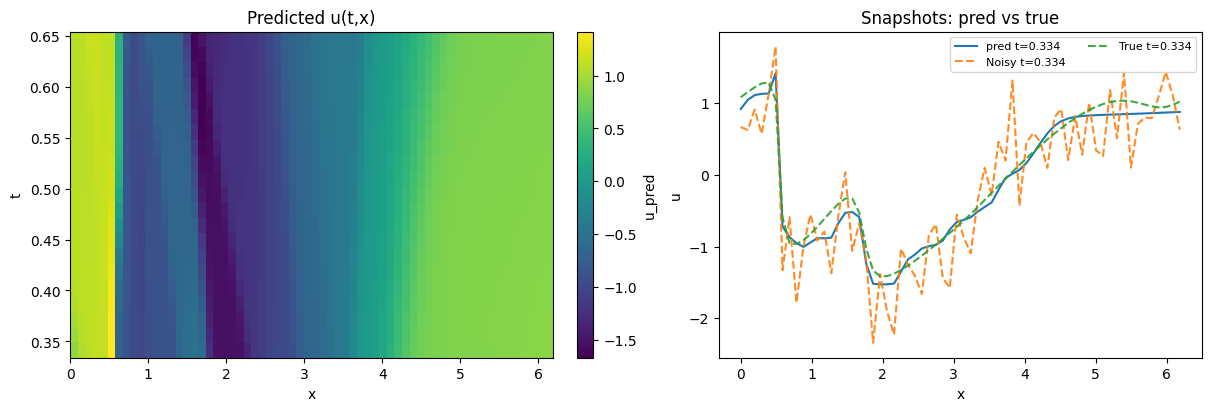

: 

In [ ]:
snapshot_comp(trainer_nl.u, stride_x, stride_t, y_noisy_np, y_np, t_np, x_np, snap_no=5, snap_which=[-1])

(<Figure size 1200x400 with 3 Axes>,
 {'t_unique': array([0.   , 0.014, 0.03 , 0.046, 0.062, 0.078, 0.094, 0.11 , 0.126,
         0.142, 0.158, 0.174, 0.19 , 0.206, 0.222, 0.238, 0.254, 0.27 ,
         0.286, 0.302, 0.318, 0.334, 0.35 , 0.366, 0.382, 0.398, 0.414,
         0.43 , 0.446, 0.462, 0.478, 0.494, 0.51 , 0.526, 0.542, 0.558,
         0.574, 0.59 , 0.606, 0.622, 0.638, 0.654, 0.67 , 0.686, 0.702,
         0.718, 0.734, 0.75 , 0.766, 0.782, 0.798, 0.814, 0.83 , 0.846,
         0.862, 0.878, 0.894, 0.91 , 0.926, 0.942, 0.958, 0.974, 0.99 ],
        dtype=float32),
  'x_unique': array([0.      , 0.098175, 0.19635 , 0.294524, 0.392699, 0.490874,
         0.589049, 0.687223, 0.785398, 0.883573, 0.981748, 1.079922,
         1.178097, 1.276272, 1.374447, 1.472622, 1.570796, 1.668971,
         1.767146, 1.865321, 1.963495, 2.06167 , 2.159845, 2.25802 ,
         2.356194, 2.454369, 2.552544, 2.650719, 2.748894, 2.847068,
         2.945243, 3.043418, 3.141593, 3.239767, 3.337942, 3.4361

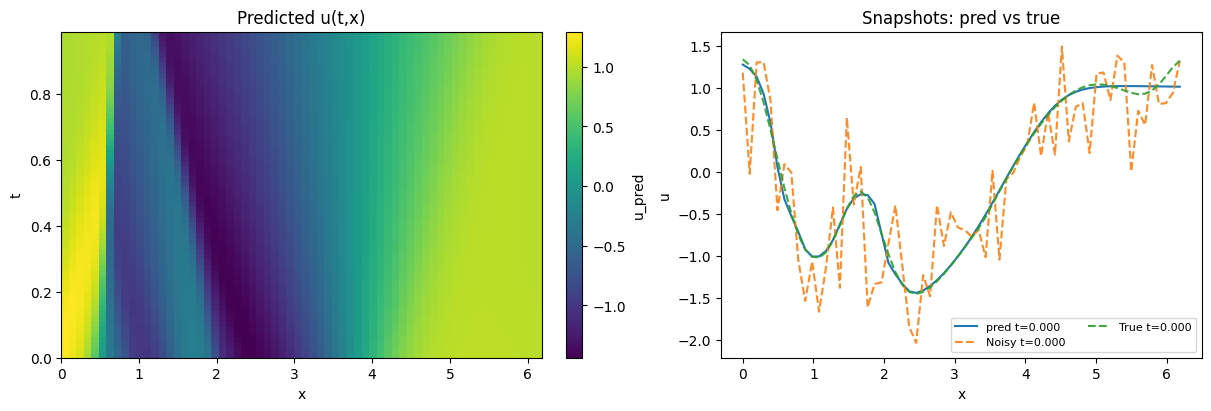

In [ ]:
snapshot_comp(trainer_nl.u, stride_x, stride_t, y_noisy_np, y_np, t_np, x_np, snap_no=1)

Running lr=1.00e-06
Epoch 0: total=1.2474e+00, data=1.1038e+00, pde=1.4367e-01, l1=9.8017e-01
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.328810
  -0.298436 · u_xx
  -0.352926 · uu_x
Epoch 1999: total=1.1889e+00, data=1.0777e+00, pde=1.1120e-01, l1=9.7745e-01
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.327703
  -0.296745 · u_xx
  -0.354289 · uu_x
Running lr=2.07e-06
Epoch 0: total=1.2442e+00, data=8.8339e-01, pde=3.6078e-01, l1=1.4847e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = -0.683317
  -0.681735 · u_xx
  -0.119611 · uu_x
Epoch 1999: total=1.2341e+00, data=9.8765e-01, pde=2.4641e-01, l1=1.4773e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = -0.673109
  -0.679150 · u_xx
  -0.118210 · uu_x
Running lr=4.28e-06
Epoch 0: total=1.3480e+00, data=1.1502e+00, pde=1.9774e-01, l1=1.2214e+00
v(F)  =  b  +  Σ w_i · f_i    (training space)
  b   = 0.350966
  -0.700997 · u_xx
  -0.169397 · uu_x
Epoch 1999: total=1.2554e+00, data=1.2068e+00, pde=4

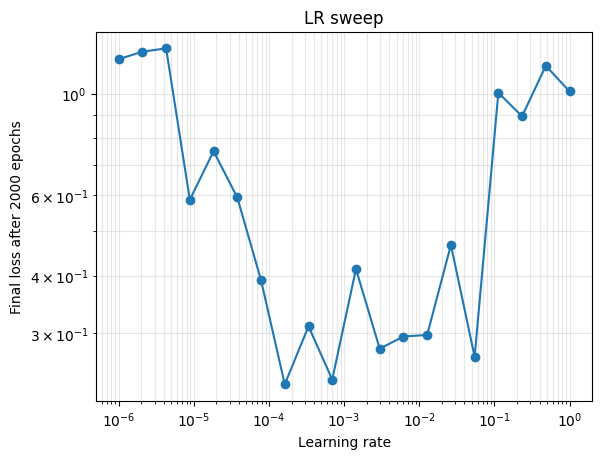

In [ ]:
lrs = np.logspace(-6, 0, num=20)   # 20 values
def quick_train(lr, epochs=1000, batch_fn=None, trainer_factory=None):
    trainer = trainer_factory(lr=lr)
    lt, ld, lp, ll, c, ck = trainer.train(epochs=epochs,
                                   batch_fn=batch_fn,
                                   train_data=True, train_pde=True,
                                   log_every=epochs+1
                                   )  # silence
    return lt
final_losses = []
quick_train(
    lr=0.001, epochs=2000,
    batch_fn=lambda: make_nonlinear_batch(batch_size=batch_size, noise=0.1),
    trainer_factory=lambda lr=lr: PDETrainerNonlinear(
        u_config=dict(n_layers=3, hidden_size=64),
        v_config=dict(input_size=2, n_layers=1, hidden_size=0, linear_only=True),
        lr=lr,
        lambda_reg=1e-5, lambda_a=1e-3,
        selected_derivs=('uu_x','u_xx')
    )    
)
for lr in lrs:
    print(f"Running lr={lr:.2e}")
    
    losses = quick_train(lr, epochs=2000,
                         batch_fn=lambda: make_nonlinear_batch(batch_size=batch_size, noise=0.1),
                         trainer_factory=lambda lr=lr: PDETrainerNonlinear(
                             u_config=dict(n_layers=3, hidden_size=64),
                             v_config=dict(input_size=2, n_layers=1, hidden_size=0, linear_only=True),
                             lr=lr,
                             lambda_reg=1e-5, lambda_a=1e-3,
                             selected_derivs=('uu_x','u_xx')
                         )
                        )
    final_losses.append(losses[-1])



plt.figure()
plt.plot(lrs, final_losses, marker="o")
plt.xscale("log")
plt.yscale("log")   # optional
plt.xlabel("Learning rate")
plt.ylabel("Final loss after 2000 epochs")
plt.title("LR sweep") 
plt.grid(True, which="both", alpha=0.3)
plt.show()


In [ ]:
lrs[final_losses.index(min(final_losses))]

np.float64(0.0001623776739188721)

In [ ]:
grid = dict(epochs=[200, 10000], batch_size=[32, 128], noise_std=[0.0, 0.05])
keys = list(grid.keys())

def trainer_factory():
    selected_derivs = ('u_xx','u_x', 'uu_x', 'uu')
    u_config = dict(n_layers=3, hidden_size=64)
    v_config = dict(input_size=len(selected_derivs), n_layers=1, hidden_size=0, linear_only=True)
    return PDETrainerNonlinear(u_config, v_config, lr=1e-3, lambda_reg=1e-5, lambda_a=1e-3,
                          selected_derivs=selected_derivs)

def batch_fn_factory(*, batch_size, noise_std):
    def make():
        return make_nonlinear_batch(batch_size=batch_size, noise=noise_std)
    return make

for vals in itertools.product(*[grid[k] for k in keys]):
    params = dict(zip(keys, vals))
    run_one(trainer_factory, batch_fn_factory, params=params, out_root="runs",
            tag_keys=("epochs","batch_size","noise_std"))


NameError: name '__file__' is not defined